In [56]:
# Note: you may need to run the following in administrator mode in Windows, esp if you had to install spacy's language models
# as admin.  See the README for details.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
import spacy
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

import praw
import re
import random
import bs4, markdown

In [76]:
# Initialize key variables here
credential_file = "credentials.key"
targetuser = "ryan_holiday" #User you are targetting, NOT necessarily your username (unless you want to do this on yourself)
test_portion = 0.1 #What fraction of the user's posts and submissions to use as the test set?
bs = 8
bptt = 70
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [3]:
try:
    with open(credential_file, 'r') as f:
        creds = f.read().split('\n')
    personal = creds[0]
    secret = creds[1]
    username = creds[2]
    password = creds[3]
except OSError as e:
    print("You didn't create a credential file! Please see sample_credentials.key")
    print("Then go to http://www.storybench.org/how-to-scrape-reddit-with-python/")
    print("And register a new app named fastai_reddit in your reddit account.")
    print("And insert the values into sample_credentials.key and save it as {}.".format(credential_file))
    raise(e)

In [66]:
reddit = praw.Reddit(client_id=personal, client_secret=secret, user_agent='fastai_reddit', username=username, \
                     password=password)
user = reddit.redditor(targetuser)

In [65]:
def noquotes(text):
    """
This function first stated out as a way to remove markdown quotes from raw reddit markdown text but now it's more of a
general purpose text parser, but the name hasn't changed.
    """
    #https://stackoverflow.com/questions/761824/python-how-to-convert-markdown-formatted-text-to-text
    html = markdown.markdown(text)
    text = ''.join(bs4.BeautifulSoup(html, 'lxml').findAll(text=True))
    t1 = re.sub(">.+?(\n|$)","",text).replace("\\n","").replace("\\","")
    return t1

In [8]:
# Test that our Reddit connection works
subreddit = reddit.subreddit('Nootropics')
test = list(subreddit.top(limit=10))[0]
print(test.title)

We need to stop this.


In [67]:
# Test getting the latest 2 comments from the user
# See: https://www.reddit.com/r/redditdev/comments/5gt42t/praw_getting_users_last_1000_comments_causing/ 
for comment in user.comments.new(limit=2):
    print(noquotes(comment.body))

Read it however you like my friend. It's designed to be one page a day (and tied to the day's date) but it will work in just about any form. 
If you fear getting caught doing something, it's probably a sign you shouldn't be doing it. 


In [68]:
# Test getting the latest 2 submissions from the user
# See: https://www.reddit.com/r/redditdev/comments/38wzzm/praw_how_to_get_submission_text/
# TODO: write a function to remove quoted text between a ">" and a new line
for sub in user.submissions.new(limit=2):
    print(noquotes(sub.selftext))

I've just finished reading Thirteen Days as well as a number of interesting articles that attempt to "correct the record" about the Cuban Missile Crisis (including this one from The Atlantic). Here is where I am confused. In Thirteen Days, RFK makes the case that Kennedy had never really wanted the Jupiter missiles in Turkey, that he had repeatedly asked for them to be removed, and possibly even thought they already had been. Therefore he was frustrated when Khrushchev demanded their removal because it was clear that the US's hardline position re: Cuba was less compelling with their existence. (Ultimately he ended up trading away their removal).
However, in a lot of contrarian histories I've read blame Kennedy for starting the crisis by placing the missiles there in 1961 (even though plans appear to predate his presidency) and more or less put the responsibility on him for pushing the USSR into a position where they needed a check on the US in Cuba. 
My question for the historians here

In [69]:
text = []
for comment in user.comments.new(limit=None):
    text.append(noquotes(comment.body))


In [96]:
print(len(text))

1000


In [70]:
subs = []
for sub in user.submissions.new(limit=None):
    newsub = noquotes(sub.selftext)
    if len(newsub) > 0:
        subs.append(newsub)

In [98]:
len(subs)

60

In [71]:
alltext = text + subs
random.shuffle(alltext)
split = round(test_portion*len(alltext))
train = pd.DataFrame()
test = pd.DataFrame()
test['text'] = alltext[0:split]
train['text'] = alltext[split:]

In [100]:
train.head()

,text
0,You've heard of a credit card right?
1,Any writers here have tattoos of their writing...
2,Frederick Douglass actually speaks about this ...
3,Look Gawker has been gone for almost two years...
4,It's built some of the biggest companies in hi...


In [101]:
test.head()

,text
0,Fantastic idea.
1,I mean that writer can fully intend to write a...
2,Thank you so much
3,\nI love Joseph Epstein. He's great.
4,"Well, according to who you ask, Seneca is an i..."


In [102]:
len(train), len(test)

(954, 106)

In [72]:
TEXTS = data.Field(lower=True, tokenize="spacy")

In [77]:
#def from_dataframes(cls, path, field, col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
#See: https://github.com/fastai/fastai/blob/master/fastai/nlp.py
md = LanguageModelData.from_dataframes(path="./", field=TEXTS, col='text',train_df=train,val_df=test,\
                                       test_df=test,bs=bs, bptt=bptt)

In [78]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [88]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [82]:
learner.lr_find()

 94%|████████████████████████████████████████████████████████████████▊    | 107/114 [00:07<00:00, 14.57it/s, loss=24.8]


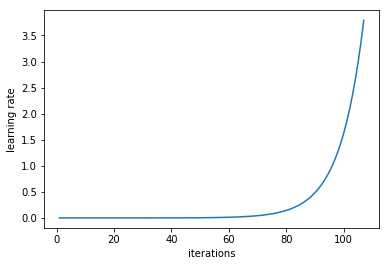

In [84]:
learner.sched.plot_lr()

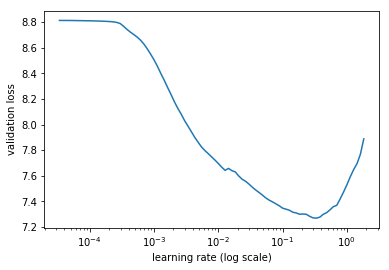

In [86]:
learner.sched.plot()

In [ ]:
lr = 3e-2

In [89]:
learner.fit(lr, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      6.873036   7.876163  
    1      6.940707   6.667976                                                                                         
    2      6.476666   6.576435                                                                                         
    3      6.76276    6.857888                                                                                         
    4      6.623416   6.718978                                                                                         
    5      6.580389   6.638887                                                                                         
    6      6.434928   6.647005                                                                                         
    7      6.764864   6.734736                                                                                         
    8  

[array([6.54034])]

In [90]:
learner.save_encoder('adam1_enc')
learner.load_encoder('adam1_enc')


FileNotFoundError: [Errno 2] No such file or directory: './models\\adam3_10_cyc_2.h5'